In [ ]:
%pip install pyDOE
%pip install wandb -q
%pip install torch==1.6.0 torchvision==0.7.0

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18178 sha256=8ffb8cb1199f7c8afe4733dd33edf8ee675012fabee88e42cce16359130f1678
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE
     |████████████████████████████████| 2.0MB 20.0MB/s 
     |████████████████████████████████| 163kB 59.0MB/s 
     |████████████████████████████████| 133kB 58.6MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
     |████████████████████████████████| 748.8MB 15kB/s 
     |████████████████████████████████| 5.9MB 30.6MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F

from torch.optim import Adam, SGD, LBFGS
from torch.utils.data import Dataset, DataLoader

from functools import partial
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat', 'burgers_shock.mat')
urllib.request.urlretrieve('https://raw.githubusercontent.com/maziarraissi/PINNs/master/main/Data/AC.mat', 'AC.mat')

urllib.request.urlretrieve('https://raw.githubusercontent.com/devzhk/Fourier-PINN/master/models/fourier2d.py', 'fourier2d.py')

('fourier2d.py', <http.client.HTTPMessage at 0x7f759e3b2bd0>)

# Code blocks

## Data

In [ ]:
class ACData(Dataset):
    '''
    members: 
        - t, x, Exact: raw data
        - X, T: meshgrid 
        - X_star, u_star: flattened (x, t), u array
        - lb, ub: lower bound and upper bound vector
        - X_u, u: boundary condition data (x, t), u
    '''
    def __init__(self, datapath):
        data = scipy.io.loadmat(datapath)

        # raw 2D data
        self.t = data['tt'].flatten()[:,None] # (201,1)
        self.x = data['x'].flatten()[:,None] # (512, 1)
        self.Exact = np.real(data['uu']).T # (201, 512)
        self.dt = 0.005
        self.dx = 2 / 512
        # Flattened sequence
        self.get_flatten_data()
        # self.get_boundary_data()

    def __len__(self):
        return self.Exact.shape[0]

    def __getitem__(self, idx):
        return self.X_star[idx], self.u_star[idx]
    
    def get_flatten_data(self):
        X, T = np.meshgrid(self.x, self.t)
        self.X, self.T = X, T
        X = np.expand_dims(X, axis=2)
        T = np.expand_dims(T, axis=2)
        self.TX = np.concatenate([T, X], axis=2)

        self.X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) # 
        self.u_star = self.Exact.flatten()[:,None]
        
        self.lb = self.X_star.min(0) # lower bound of (x, t): 2-dimensional vector 
        self.ub = self.X_star.max(0) # upper bound of (x, t): 2-dimensional vector

    def get_boundary_data(self):
        xx1 = np.hstack((self.X[0:1,:].T, self.T[0:1,:].T))
        uu1 = self.Exact[0:1,:].T
        xx2 = np.hstack((self.X[:,0:1], self.T[:,0:1]))
        uu2 = self.Exact[:,0:1]
        xx3 = np.hstack((self.X[:,-1:], self.T[:,-1:]))
        uu3 = self.Exact[:,-1:]
        self.X_u = np.vstack([xx1, xx2, xx3])
        self.u = np.vstack([uu1, uu2, uu3])
    
    def sample_xt(self, N=10000):
        '''
        Sample (x, t) pairs within the boundary
        Return:
            - X_f: (N, 2) array
        '''
        X_f = self.lb + (self.ub-self.lb)*lhs(2, N)
        X_f = np.vstack((X_f, self.X_u))
        return X_f

    def sample_xu(self, N=100):
        '''
        Sample N points from boundary data
        Return: 
            - X_u: (N, 2) array 
            - u: (N, 1) array
        '''
        idx =  np.random.choice(self.X_u.shape[0], N, replace=False)
        X_u = self.X_u[idx, :]
        u = self.u[idx,:]
        return X_u, u

    def sample_TX(self, shape=(100, 256)):
        xs = np.linspace(self.lb[0], self.ub[0], num=shape[1])
        ts = np.linspace(self.lb[1], self.ub[1], num=shape[0])
        X, T = np.meshgrid(xs, ts)
        X = np.expand_dims(X, axis=2)
        T = np.expand_dims(T, axis=2)
        TX = np.concatenate([T, X], axis=2)
        return TX
    
    def padded_TX(self,shape=(100, 256), dx=None, dt=None):
        '''
        Params:
            - shape: (N, M)
        Return: 
            - padded TX: shape (N + 2, M + 2), add padding to the beginning and end of each dimension 
        '''
        if dx is None:
            dx = self.dx
        if dt is None:
            dt = self.dt
        
        xs = np.linspace(self.lb[0]-dx, self.ub[0]+dx, num=shape[1]+2)
        ts = np.linspace(self.lb[1]-dt, self.ub[1]+dt, num=shape[0]+2)
        X, T = np.meshgrid(xs, ts)
        X = np.expand_dims(X, axis=2)
        T = np.expand_dims(T, axis=2)
        TX = np.concatenate([T, X], axis=2)
        return TX

In [ ]:
class BurgerData(Dataset):
    '''
    members: 
        - t, x, Exact: raw data
        - X, T: meshgrid 
        - X_star, u_star: flattened (x, t), u array
        - lb, ub: lower bound and upper bound vector
        - X_u, u: boundary condition data (x, t), u
    '''
    def __init__(self, datapath):
        data = scipy.io.loadmat(datapath)

        # raw 2D data
        self.t = data['t'].flatten()[:,None] # (100,1)
        self.x = data['x'].flatten()[:,None] # (256, 1)
        self.Exact = np.real(data['usol']).T # (100, 256)
        self.dt = 0.01
        self.dx = 2 / 255
        # Flattened sequence
        self.get_flatten_data()
        # self.get_boundary_data()

    def __len__(self):
        return self.Exact.shape[0]

    def __getitem__(self, idx):
        return self.X_star[idx], self.u_star[idx]
    
    def get_flatten_data(self):
        X, T = np.meshgrid(self.x, self.t)
        self.X, self.T = X, T
        X = np.expand_dims(X, axis=2)
        T = np.expand_dims(T, axis=2)
        self.TX = np.concatenate([T, X], axis=2)

        self.X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) # 
        self.u_star = self.Exact.flatten()[:,None]
        
        self.lb = self.X_star.min(0) # lower bound of (x, t): 2-dimensional vector 
        self.ub = self.X_star.max(0) # upper bound of (x, t): 2-dimensional vector

    def get_boundary_data(self):
        xx1 = np.hstack((self.X[0:1,:].T, self.T[0:1,:].T))
        uu1 = self.Exact[0:1,:].T
        xx2 = np.hstack((self.X[:,0:1], self.T[:,0:1]))
        uu2 = self.Exact[:,0:1]
        xx3 = np.hstack((self.X[:,-1:], self.T[:,-1:]))
        uu3 = self.Exact[:,-1:]
        self.X_u = np.vstack([xx1, xx2, xx3])
        self.u = np.vstack([uu1, uu2, uu3])
    
    def sample_xt(self, N=10000):
        '''
        Sample (x, t) pairs within the boundary
        Return:
            - X_f: (N, 2) array
        '''
        X_f = self.lb + (self.ub-self.lb)*lhs(2, N)
        X_f = np.vstack((X_f, self.X_u))
        return X_f

    def sample_xu(self, N=100):
        '''
        Sample N points from boundary data
        Return: 
            - X_u: (N, 2) array 
            - u: (N, 1) array
        '''
        idx =  np.random.choice(self.X_u.shape[0], N, replace=False)
        X_u = self.X_u[idx, :]
        u = self.u[idx,:]
        return X_u, u

    def sample_TX(self, shape=(100, 256)):
        xs = np.linspace(self.lb[0], self.ub[0], num=shape[1])
        ts = np.linspace(self.lb[1], self.ub[1], num=shape[0])
        X, T = np.meshgrid(xs, ts)
        X = np.expand_dims(X, axis=2)
        T = np.expand_dims(T, axis=2)
        TX = np.concatenate([T, X], axis=2)
        return TX
    
    def padded_TX(self,shape=(100, 256), dx=None, dt=None):
        '''
        Params:
            - shape: (N, M)
        Return: 
            - padded TX: shape (N + 2, M + 2), add padding to the beginning and end of each dimension 
        '''
        if dx is None:
            dx = self.dx
        if dt is None:
            dt = self.dt
        
        xs = np.linspace(self.lb[0]-dx, self.ub[0]+dx, num=shape[1]+2)
        ts = np.linspace(self.lb[1]-dt, self.ub[1]+dt, num=shape[0]+2)
        X, T = np.meshgrid(xs, ts)
        X = np.expand_dims(X, axis=2)
        T = np.expand_dims(T, axis=2)
        TX = np.concatenate([T, X], axis=2)
        return TX

## Basics

In [ ]:
def count_parameters(model):
    count = 0
    for p in model.parameters():
        count += p.numel()
    return count


def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def zero_grad(params):
    '''
    set grad field to 0
    '''
    if isinstance(params, torch.Tensor):
        if params.grad is not None:
            params.grad.detach()
            params.grad.zero_()
    else:
        for p in params:
            if p.grad is not None:
                p.grad.detach()
                p.grad.zero_()

## Loss

### MSE loss

In [ ]:
def mse(X, Y):
    loss = (X - Y) ** 2
    return loss.mean()

### PDE loss- finite difference method

In [ ]:
def PDEerr_FDM(model, tx, nu, dt, dx):
    '''
    Compute the residual of Burgers: 
        residual = u_t + u * u_x - nu * u_{xx} : (N,1)
    
    Params: 
        - model: input (T size, X size, 2), output (T size, X size)
        - tx: (T size, X size, 2)
        - nu: constant of PDE
    Return: 
        - residual : (T size, X size) 
    '''
    u = model(tx)
    padded_u = F.pad(u, (1,1,1,1), mode='constant', value=0)

    # central difference to compute du/dt
    diff_ut = padded_u[2:, 1:-1] - padded_u[:-2, 1:-1]
    grad_t = diff_ut / (2 * dt)

    # central difference to compute du/dx 
    diff_ux = padded_u[1:-1, 2:] - padded_u[1:-1, :-2]
    grad_x = diff_ux / (2 * dx)

    # central difference to compute d^2u/dx^2
    diff_uxx = padded_u[1:-1, 2:] + padded_u[1:-1, :-2] - 2 * u
    gradgrad_x = diff_uxx / dx ** 2

    residual = grad_t - nu * gradgrad_x + 5*((u**3)-u)
    return residual

### Compute PDE residual

In [ ]:
def eval_residual(model, tx, nu, dt, dx):
    '''
    Compute the residual of burgers: 
        residual = u_t + u * u_x - nu * u_{xx} : (N,1)
    
    Params: 
        - model: input (T size, X size, 2), output (T size, X size)
        - tx: (T size, X size, 2)
        - nu: constant of PDE
    Return: 
        - residual : (T size - 2, X size -2) 
    '''
    padded_u = model(tx)

    # central difference to compute du/dt
    diff_ut = padded_u[2:, 1:-1] - padded_u[:-2, 1:-1]
    grad_t = diff_ut / (2 * dt)

    # central difference to compute du/dx 
    diff_ux = padded_u[1:-1, 2:] - padded_u[1:-1, :-2]
    grad_x = diff_ux / (2 * dx)

    # central difference to compute d^2u/dx^2
    diff_uxx = padded_u[1:-1, 2:] + padded_u[1:-1, :-2] - 2 * padded_u[1:-1, 1:-1]
    gradgrad_x = diff_uxx / dx ** 2

    residual = grad_t + 5*((padded_u[1:-1, 1:-1]**3)-padded_u[1:-1, 1:-1]) - nu * gradgrad_x
    return residual

## FNN

In [ ]:
# Complex multiplication
def compl_mul2d(a, b):
    # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
    op = partial(torch.einsum, "bixy,ioxy->boxy")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)


class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.rfft(x, 2, normalized=True, onesided=True)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.in_channels,
                             x.size(-2), x.size(-1)//2 + 1, 2, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.irfft(out_ft, 2, normalized=True, onesided=True,
                        signal_sizes=(x.size(-2), x.size(-1)))
        return x


class FNN2d(nn.Module):
    def __init__(self, modes1, modes2,  width, layers=None):
        super(FNN2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        # input channel is 3: (a(x, y), x, y)
        if layers is None:
            layers = [width] * 4

        self.fc0 = nn.Linear(2, layers[0])

        self.sp_convs = nn.ModuleList([SpectralConv2d(
            in_size, out_size, self.modes1, self.modes2) for in_size, out_size in zip(layers, layers[1:])])

        self.ws = nn.ModuleList([nn.Conv1d(in_size, out_size, 1)
                                 for in_size, out_size in zip(layers, layers[1:])])

        self.fc1 = nn.Linear(layers[-1], width)
        self.fc2 = nn.Linear(width, 1)

    def forward(self, x):
        '''
        Input: 
            - x : (batch size, x_grid, y_grid, 2)
        Output: 
            - x: (batch size, x_grid, y_grid, 1)
        '''
        length = len(self.ws)
        x = x.unsqueeze(dim=0)
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        for i, (speconv, w) in enumerate(zip(self.sp_convs, self.ws)):
            x1 = speconv(x)
            x2 = w(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
            x = x1 + x2
            if i != length-1:
                x = F.relu(x)
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.squeeze()

## Trainer

In [ ]:
def train(model, X_u, u, X_f, 
          dt, dx,
          gamma=1.0, nu=1.0, num_epoch=100,
          device=torch.device('cpu'), optim='LBFGS'):
    '''
    Params:
        - model: neural network  
        - X_u: shape (T, X, 2), where T is the time length, X is the x length
        - u: (T, X) target value of u(x,t)
        - X_f: shape (Tf, Xf, 2), PDE equation
        - gamma: weight of mse_u loss
        - nu: PDE coefficient. 
    Return:
        - model: trained network
    '''
    model.to(device)
    model.train()
    optimizer = LBFGS(model.parameters(), 
                      lr=1.0, 
                      max_iter=50000, 
                      max_eval=50000, 
                      history_size=50,
                      tolerance_grad=1e-5, 
                      tolerance_change=1.0 * np.finfo(float).eps,
                      line_search_fn="strong_wolfe")
    # training stage
    xts_u = torch.from_numpy(X_u).float().to(device)
    us = torch.from_numpy(u).float().to(device)

    xt_f = torch.from_numpy(X_f).float().to(device)

    iter = 0

    def loss_closure():
        nonlocal iter
        iter = iter + 1

        optimizer.zero_grad()
        
        # MSE loss of prediction error
        # print(xts.shape)
        pred_u = model(xts_u)
        mse_u = mse(pred_u, us)
        
        # MSE loss of PDE constraint
        f = PDEerr_FDM(model, xt_f, nu, dt, dx)

        mse_f = torch.mean(f ** 2)
        loss = gamma * mse_u + mse_f
        loss.backward()
        
        if iter % 200==0:
            print('Iter: {}, total loss: {}, mse_u: {}, mse_f: {}'.
                format(iter, loss.item(), mse_u.item(), mse_f.item()))
        return loss
    
    optimizer.step(loss_closure)

    return model

In [ ]:
def trainsgd(model, X_u, u, X_f, 
          dt, dx,
          gamma=1.0, nu=1.0, num_epoch=100,
          device=torch.device('cpu')):
    '''
    Params:
        - model: neural network  
        - X_u: shape (T, X, 2), where T is the time length, X is the x length
        - u: (T, X) target value of u(x,t)
        - X_f: shape (Tf, Xf, 2), PDE equation
        - gamma: weight of mse_u loss
        - nu: PDE coefficient. 
    Return:
        - model: trained network
    '''
    model.to(device)
    model.train()
    optimizer = Adam(model.parameters(), lr=0.005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2)
    xts_u = torch.from_numpy(X_u).float().to(device)
    us = torch.from_numpy(u).float().to(device)

    xt_f = torch.from_numpy(X_f).float().to(device)

    for e in range(num_epoch):
        optimizer.zero_grad()
        pred_u = model(xts_u)
        mse_u = mse(pred_u, us)
        # MSE loss of PDE constraint
        f = PDEerr_FDM(model, xt_f, nu, dt, dx)

        mse_f = torch.mean(f ** 2)
        loss = gamma * mse_u + mse_f
        loss.backward()
        optimizer.step()
        scheduler.step()
        if e % 200==0:
            print('Iter: {}, total loss: {}, mse_u: {}, mse_f: {}'.
                format(e, loss.item(), mse_u.item(), mse_f.item()))
    return model

## Visualization

In [ ]:
def eval_plot(model, trainset,
              nu, tag='default',
              device=torch.device('cpu')):
    eval_TX = torch.tensor(trainset.TX).float().to(device)
    target_u = torch.tensor(trainset.Exact).float().to(device)
    padded_TX = torch.tensor(trainset.padded_TX()).float().to(device)
    
    with torch.no_grad():
        pred_u = model(eval_TX)
        residual = eval_residual(model, padded_TX, nu, trainset.dt, trainset.dx)
    err_u = target_u - pred_u
    relative_error = torch.norm(err_u) / torch.norm(target_u)
    
    print('Relative error ||pred_u - target_u||_2 / ||target_u||_2: {}'.format(relative_error.item()))
    print('Averaged PDE L1 residual error: {}'.format(torch.abs(residual).mean().item()))

    t = trainset.t
    x = trainset.x
    err_u = err_u.cpu().numpy()
    residual = residual.cpu().numpy()
    pred_u = pred_u.cpu().numpy()
    # absolute error plot
    plt.imshow(np.abs(err_u.T), interpolation='nearest', cmap='Blues', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
    plt.xlabel('$t$', fontsize=15)
    plt.ylabel('$x$', fontsize=15)
    plt.title('Absolute approximation error at each point')
    plt.colorbar()
    plt.savefig('abs_err-%s.png' % tag)
    plt.show()

    # Approximation at specific time slice
    tvalues = [25, 50, 75]
    fig, axes = plt.subplots(len(tvalues), 1, sharex=True)
    fig.set_size_inches(12, 8)
    for ax, tstep in zip(axes, tvalues):
        ax.plot(x, pred_u[tstep, :], 'r--', linewidth=3, label='Prediction', alpha=0.9)
        ax.plot(x, trainset.Exact[tstep, :], 'b-', linewidth=3, label='Exact', alpha=0.7)
        ax.set_title('t=0.%d' % tstep, fontsize=15)
        ax.set_ylabel('$u(x,t)$', fontsize=15)
    ax.set_xlabel('$x$', fontsize=15)
    ax.legend(loc='right')
    plt.savefig('timeslice-%s.png' % tag)

    fig, ax = plt.subplots()
    # residual error plot
    
    plt.imshow(residual.T, interpolation='nearest', cmap='RdBu', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
    plt.xlabel('$t$', fontsize=15)
    plt.ylabel('$x$', fontsize=15)
    plt.colorbar()
    plt.savefig('pde-residual-%s.png' % tag)
    plt.show()

# Train - Burgers

## Prepare data

In [ ]:
datapath = 'AC.mat'
trainset = ACData(datapath)

lenT = 100
lenX = 256 
dt = 0.99 / (lenT - 1)
dx = 2 / (lenX - 1)
# PDE loss part 
txs = trainset.sample_TX(shape=(lenT, lenX))
# approximation of u
TX_u = trainset.TX
us = trainset.Exact

## Train model

TODO: 
- try other optimizer such as Adam



In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
nu = 0.0001

modes1 = 8
modes2 = 8
width0 = 8
layers = [width0]*16

In [38]:
%%time
fnn = FNN2d(modes1, modes2, width=width0, layers=layers)

fnn = trainsgd(fnn, TX_u, us, X_f=txs,num_epoch=5000,
            dt=dt, dx=dx, nu=nu, device=device)

Iter: 0, total loss: 1.821562647819519, mse_u: 0.4623417854309082, mse_f: 1.3592208623886108
Iter: 200, total loss: 0.4909171462059021, mse_u: 0.47906383872032166, mse_f: 0.011853312142193317
Iter: 400, total loss: 0.4907970428466797, mse_u: 0.4795116186141968, mse_f: 0.01128543633967638
Iter: 600, total loss: 0.48260870575904846, mse_u: 0.4779816269874573, mse_f: 0.00462707132101059
Iter: 800, total loss: 0.49075639247894287, mse_u: 0.4790555536746979, mse_f: 0.011700848117470741
Iter: 1000, total loss: 0.48970919847488403, mse_u: 0.47762730717658997, mse_f: 0.012081880122423172
Iter: 1200, total loss: 0.48658502101898193, mse_u: 0.4741809666156769, mse_f: 0.012404064647853374
Iter: 1400, total loss: 0.4666721820831299, mse_u: 0.4475710988044739, mse_f: 0.01910109631717205
Iter: 1600, total loss: 0.406817764043808, mse_u: 0.39337629079818726, mse_f: 0.013441482558846474
Iter: 1800, total loss: 0.3658665120601654, mse_u: 0.3563837707042694, mse_f: 0.00948274228721857
Iter: 2000, total 

## Eval and plot

Relative error ||pred_u - target_u||_2 / ||target_u||_2: 0.6957486867904663
Averaged PDE L1 residual error: 1.0704290866851807


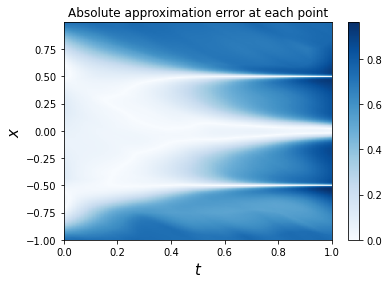

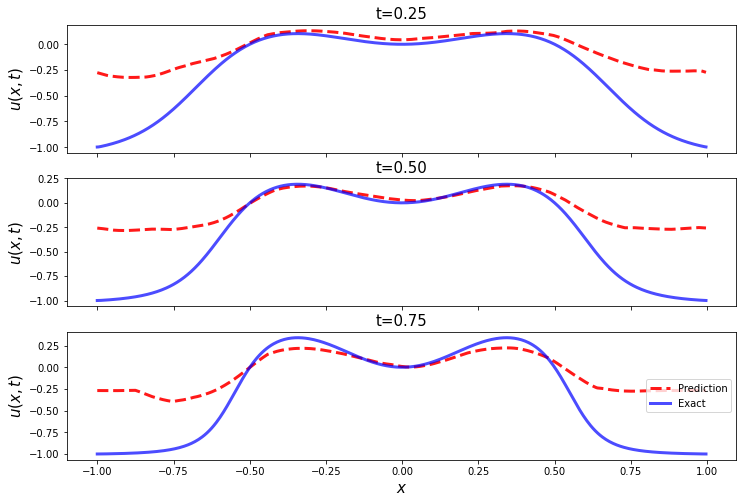

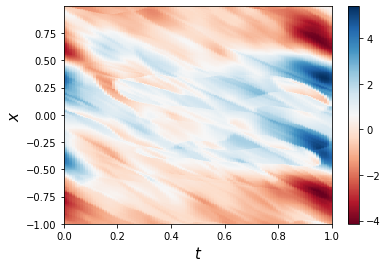

In [39]:
eval_plot(fnn, trainset, nu, tag='fnn', device=device)

# Train-Allen 

# Compute number of parameters

In [40]:
count_parameters(fnn)

246945